In [81]:
import numpy as np
from numpy import zeros, eye, array, r_, diag, ones, log, zeros_like, pi, exp, log10, sort, quantile, linspace, vstack
from numpy import save, nanmean
from numpy.random import randn, rand, randint, default_rng
from numpy.random import normal
from numpy import isfinite
from numpy.linalg import solve, det, inv, norm
from numpy import logspace

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from collections import OrderedDict
import copy

from warnings import catch_warnings, filterwarnings

from autograd import jacobian, grad
import autograd.numpy as anp
from autograd.numpy import ones as aones
from autograd.numpy import zeros as azeros
from autograd.numpy import exp as aexp
from autograd.numpy.linalg import det as adet
from autograd.numpy import log as alog
from autograd.numpy import diag as adiag
from autograd.numpy.linalg import norm as anorm
import autograd.scipy as asp
from autograd.scipy.stats import norm as andist
import autograd as ag
from autograd.scipy.special import gamma as agamma

from scipy.stats import multivariate_normal as MVN
from scipy.optimize import fsolve, bisect
from scipy.stats import norm as ndist
from scipy.stats import uniform as udist
from scipy.stats import beta as abetadist
from scipy.linalg import qr, lstsq
from scipy.special import gamma

from g_and_k_functions import GandK
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from HMC.static_hmc import HMC
from utils import ESS_univariate, ESS

from mici.samplers import ChainState
from mici.systems import DenseConstrainedEuclideanMetricSystem as DCEMS
from mici.systems import EuclideanMetricSystem as EMS
from mici.integrators import ConstrainedLeapfrogIntegrator as CLI
from mici.integrators import LeapfrogIntegrator as LI
from mici.samplers import DynamicMultinomialHMC as DMHMC
from mici.samplers import StaticMetropolisHMC as SMHMC

import time

from Manifolds.Manifold import Manifold
# from Zappa.zappa import zappa_sampling_storecomps

from itertools import product
import scipy.linalg as la

import math
from copy import deepcopy

In [53]:
# Parameters
θ0        = array([3.0, 1.0, 2.0, 0.5]) # True parameter value
m         = 50                          # Number of latent variables
d         = 4 + m                       # Dimensionality of ξ=(θ, z)
# seed=1234

In [181]:
def f(ξ):
    """Deterministic simulator f: ξ -> y."""
    return ξ[0] + ξ[1]*(1 + 0.8*(1 - aexp(-ξ[2]*ξ[4:]))/(1 + aexp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]

def data_generator(θ0, m, seed):
    """Stochastic Simulator. Generates y given θ."""
    rng = default_rng(seed)
    z = rng.normal(size=m)
    return f(r_[θ0, z])

def Jf_transpose(ξ):
    """Transpose of the Jacobian of f."""
    return vstack((
        aones(len(ξ[4:])),
        (1 + 0.8 * (1 - aexp(-ξ[2] * ξ[4:])) / (1 + aexp(-ξ[2] * ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3]) * ξ[4:],
        8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * aexp(ξ[2]*ξ[4:]) / (5 * (1 + aexp(ξ[2]*ξ[4:]))**2),
        ξ[1]*ξ[4:]*((1+ξ[4:]**2)**ξ[3])*(1 + 9*aexp(ξ[2]*ξ[4:]))*alog(1 + ξ[4:]**2) / (5*(1 + aexp(ξ[2]*ξ[4:]))),
        adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))
    ))

def Jf(ξ):
    """Jacobian of f."""
    return Jf_transpose(ξ).T

def check_jacobian(tol=1e-12):
    """Checks if Jacobian function is correct."""
    ξ = r_[θ0, randn(m)]
    return np.max(abs(Jf(ξ) - jacobian(f)(ξ))) < tol

Jf_autograd = jacobian(f)

def log_pθ_beta(θ):
    """Beta logprior for θ."""
    assert len(θ) == 4, "θ must be 4-dimensional but has length {}".format(len(θ))
    #return abetadist.logpdf(θ, a=2, b=2, scale=10).sum()
    # α=2.0 and β=2.0
    return (alog(θ/10) + alog(1-θ/10) -alog(2) -alog(2) + alog(agamma(4))- alog(10)).sum()
    
    
def log_pz(z):
    """Normal logprior for z."""
    return andist.logpdf(z).sum()

def logprior_beta(ξ):
    """Log prior on ξ using Beta(2,2) for θ."""
    return log_pθ_beta(ξ[:4]) + log_pz(ξ[4:])

def neg_logprior_beta(ξ):
    return - logprior_beta(ξ)

def sample_θ_beta():
    """Samples θ from Beta prior. """
    return abetadist.rvs(a=2, b=2, scale=10, size=4) #10*abetadist.rvs(a=2, b=2, scale=1, size=4)

def sample_prior_beta():
    """Samples from prior for ξ where p(θ) is a Beta(2,2)."""
    return anp.r_[sample_θ_beta(), randn(m)]

def log_normal_kernel(ξ, ystar, ϵ):
    """Log normal kernel density."""
    u = anorm(f(ξ) - ystar)
    return -u**2/(2*(ϵ**2)) -0.5*alog(2*pi*(ϵ**2))

def log_abc_posterior_beta(ξ, ystar, ϵ):
    """Log posterior density. """
    return logprior_beta(ξ) + log_normal_kernel(ξ, ystar, ϵ)

# def find_point_on_manifold(ystar, ϵ, max_iter=1000):
#     """Find a point on the data manifold."""
#     i = 0
#     with catch_warnings():
#         filterwarnings('error')
#         while i <= max_iter:
#             i += 1
#             try: 
#                 ξ_guess = sample_prior_beta()
#                 ξ_found = fsolve(lambda ξ: r_[f(ξ) - ystar, azeros(4)], ξ_guess)
#                 if not isfinite([log_abc_posterior_beta(ξ_found, ystar, ϵ)]):
#                     pass
#                 else:
#                     return ξ_found

#             except RuntimeWarning:
#                 continue
#         raise ValueError("Couldn't find a point, try again.")

def find_point_on_manifold(ystar, ϵ, max_iter=1000, tol=1.49012e-08, m=50):
    """Find a point on the data manifold."""
    i = 0
    with catch_warnings():
        filterwarnings('error')
        while i <= max_iter:
            i += 1
            try: 
                # Sample θ from the prior
                θfixed = sample_θ_beta()
                function = lambda z: f(r_[θfixed, z]) - ystar
                z_guess  = randn(m)
                z_found  = fsolve(function, z_guess, xtol=tol)
                ξ_found  = r_[θfixed, z_found]
                if not isfinite([log_abc_posterior_beta(ξ_found, ystar, ϵ)]):
                    pass
                else:
                    return ξ_found

            except RuntimeWarning:
                continue
        raise ValueError("Couldn't find a point, try again.")    
        
def find_point_on_manifold_from_θ(ystar, θfixed, ϵ, max_iter=2000, tol=1.49012e-08):
    """Same as the above but we provide the θfixed. Can be used to find a point where
    the theta is already θ0."""
    function = lambda z: f(r_[θfixed, z]) - ystar
    z_guess  = randn(m)
    z_found  = fsolve(function, z_guess, xtol=tol)
    ξ_found  = r_[θfixed, z_found]
    if not isfinite([log_abc_posterior_beta(ξ_found, ystar, ϵ)]):
        raise ValueError("Couldn't find a point.")
    else:
        return ξ_found

# def beta_pdf(x, α, β, loc=0.0, scale=1.0):
#     y = (x - loc) / scale
#     return ((y**(α-1))*((1-y)**(β-1)) / (gamma(α)*gamma(β)*scale)) * gamma(α + β)
# def beta_logpdf(x, α, β, loc=0.0, scale=1.0):
#     y = (x - loc) / scale
#     return (α - 1)*log(y) + (β - 1)*log(1-y) - log(gamma(α)) - log(gamma(β)) + log(gamma(α + β)) - log(scale)

        
def is_on_manifold(ξ, ystar, tol=1e-8):
    """Checks if ξ is on the ystar manifold."""
    return np.max(abs(f(ξ) - ystar)) < tol
        
q = MVN(zeros(d), eye(d))

In [55]:
ystar = data_generator(θ0, m, seed=1234)

In [56]:
# # T = 0.2
# # B = 5
# #### Try keeping 
# B = 5
# δ = 0.1
# T = B * δ
# print("B: {}\nδ: {}\nT: {}".format(B, δ, T))

In [57]:
def generate_powers_of_ten(max_exponent, min_exponent):
    """E.g. generate_powers_of_ten(2, -1) will return 100, 10, 0, 0.1."""
    number_of_powers = max_exponent + abs(min_exponent) + 1
    return logspace(start=max_exponent, stop=min_exponent, num=number_of_powers, endpoint=True)

In [58]:
# max_exponent = 3
# min_exponent = -5
# total = max_exponent + abs(min_exponent) + 1
# ϵs = generate_powers_of_ten(3, -5) #logspace(start=max_exponent, stop=min_exponent, num=total, endpoint=True)
# seeds  = array([1111, 2222, 3333, 4444, 5555, 6666, 7777, 8888, 9999])
# assert len(ϵs) == len(seeds)
# ystars = [ystar for ϵ in ϵs] #[data_generator(θ0, m, seed=seed) for seed in seeds]
# n_repeats = 1
# N_samples = 1000

In [59]:
# ξ0s = []
# # find point that works for smallest ϵ
ξ0_found = find_point_on_manifold(ystar, ϵ=1e-5, max_iter=5000, tol=1e-16)
# ξ0s = [ξ0_found for ϵ in ϵs]

In [836]:
def run_thug(ξ0, T, B, N_samples, α, ystar, ϵ, method='qr'):
    """Runs THUG with various settings."""
    start_time = time.time()
    thug_samples, thug_acc = HugTangentialMultivariate(
        x0=ξ0,
        T=T,
        B=B,
        N=N_samples,
        α=α,
        q=q,
        logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵ),
        jac=Jf,
        method=method
    )
    runtimeTHUG = time.time() - start_time
    return min(ESS_univariate(thug_samples)) / runtimeTHUG, thug_acc.mean()

def run_crwm(ξ0, T, B, N_samples, ystar, tol=1e-10, rev_tol=1e-10, norm_ord=2):
    """Runs C-RWM with various settings."""
    manifold = GKManifold(ystar=ystar)
    # Run
    start_time = time.time()
    crwm_samples, crwm_evals, crwm_acc  = zappa_sampling_storecomps_rattle(ξ0, manifold, N_samples, T, B, tol=tol, rev_tol=rev_tol, norm_ord=norm_ord)
    runtimeCRWM = time.time() - start_time
    return min(ESS_univariate(crwm_samples)) / runtimeCRWM, crwm_acc.mean()

In [835]:
def run_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=0.0, method='qr'):
    """For each ϵ and for each B it runs THUG and computes its minESS/runtime."""
    THUG_CC = zeros((len(ϵs), len(Bs)))
    THUG_AP = zeros((len(ϵs), len(Bs)))
    for ϵ_ix, ϵ in enumerate(ϵs):
        for B_ix, B in enumerate(Bs):
            print("ϵ = ", ϵ, " B = ", B)
            thug_cc, thug_ap = run_thug(ξ0_found, B*δ, B, N_samples, α, ystar, ϵ, method=method)
            THUG_CC[ϵ_ix, B_ix] = thug_cc
            THUG_AP[ϵ_ix, B_ix] = thug_ap
    return THUG_CC, THUG_AP

def avg_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α, method, n_runs):
    """Basically averages results of `run_thug_for_various_ϵ_and_B` for several runs."""
    THUG_CC = zeros((len(ϵs), len(Bs)))
    THUG_AP = zeros((len(ϵs), len(Bs)))
    for i in range(n_runs):
        thug_cc, thug_ap = run_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=α, method=method)
        THUG_CC += (thug_cc / n_runs)
        THUG_AP += (thug_ap / n_runs)
    return THUG_CC, THUG_AP

def run_crwm_for_various_B(Bs, δ, N_samples, tol=1e-16, rev_tol=1e-16, norm_ord=2):
    """Basically same as above but since C-RWM is on the manifold we don't need to run it for different ϵs."""
    CRWM_CC = zeros(len(Bs))
    CRWM_AP = zeros(len(Bs))
    for B_ix, B in enumerate(Bs):
        print("B = ", B)
        crwm_cc, crwm_ap = run_crwm(ξ0_found, B*δ, B, N_samples, ystar, tol=tol, rev_tol=rev_tol, norm_ord=norm_ord)
        CRWM_CC[B_ix] = crwm_cc
        CRWM_AP[B_ix] = crwm_ap
    return CRWM_CC, CRWM_AP

def avg_crwm_for_various_B(Bs, δ, N_samples, n_runs, tol=1e-16, rev_tol=1e-16):
    """Averages `run_crwm_for_various_B` for a number of runs."""
    CRWM_CC = zeros(len(Bs))
    CRWM_AP = zeros(len(Bs))
    for i in range(n_runs):
        crwm_cc, crwm_ap = run_crwm_for_various_B(Bs, δ, N_samples, tol=tol, rev_tol=rev_tol)
        CRWM_CC += (crwm_cc / n_runs)
        CRWM_AP += (crwm_ap / n_runs)
    return CRWM_CC, CRWM_AP

In [154]:
ϵs        = generate_powers_of_ten(0, -4) #generate_powers_of_ten(2, -8)[::2]
δ         = 0.05 #0.01
N_samples = 10000
Bs        = [5, 10, 20]

In [820]:
# I just want to figure out how Jacobian computations are needed in the Newton step.
def check_n_jacobian_comp_per_newton_step(m, δ, N_samples, B, tol=1e-10, rev_tol=1e-10, maxiter=50, tol_init_point=1e-16, norm_ord=2):
    """Basically runs N_samples of C-RWM and prints out how many Jacobian computations
    were used during the Newton step."""
    θ0        = array([3.0, 1.0, 2.0, 0.5])
    d         = 4 + m                      
    ystar = data_generator(θ0, m, seed=1234)
    print("Dimensionality: ", m)
    print("Dim(ystar): ", ystar.shape)
    ξ0 = find_point_on_manifold(ystar, ϵ=1e-5, max_iter=5000, tol=tol_init_point, m=m)
    print("Dim(ξ0): ", ξ0.shape)
    manifold = GKManifold(ystar=ystar)
    print("M dim and codim: ", manifold.get_dimension(), manifold.get_codimension())
    return zappa_sampling_storecomps_rattle(ξ0, manifold, N_samples, B*δ, B, tol, rev_tol, maxiter, norm_ord)

In [238]:
___ = check_n_jacobian_comp_per_newton_step(m=50, δ=0.05, N_samples=1, B=1, tol=1e-16, rev_tol=1e-16)

Dimensionality:  50
Dim(ystar):  (50,)
Dim(ξ0):  (54,)
M dim and codim:  4 50
Iteration:  0
Leapfrog Step:  0
	Constrained Step FW:  51
	Constrained Step BW:  51


In [913]:
run_thug(ξ0_found, 5*δ, 5, 1000, 0.0, ystar, 1e-2)

(2.049899833007743, 1.0)

In [155]:
OUT1, OUT2 = run_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=0.0, method='linear')

ϵ =  1.0  B =  5
ϵ =  1.0  B =  10
ϵ =  1.0  B =  20
ϵ =  0.1  B =  5
ϵ =  0.1  B =  10
ϵ =  0.1  B =  20
ϵ =  0.01  B =  5
ϵ =  0.01  B =  10
ϵ =  0.01  B =  20
ϵ =  0.001  B =  5
ϵ =  0.001  B =  10
ϵ =  0.001  B =  20
ϵ =  0.0001  B =  5
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  20


In [156]:
OUT3, OUT4 = run_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=0.99)

ϵ =  1.0  B =  5
ϵ =  1.0  B =  10
ϵ =  1.0  B =  20
ϵ =  0.1  B =  5
ϵ =  0.1  B =  10
ϵ =  0.1  B =  20
ϵ =  0.01  B =  5
ϵ =  0.01  B =  10
ϵ =  0.01  B =  20
ϵ =  0.001  B =  5
ϵ =  0.001  B =  10
ϵ =  0.001  B =  20
ϵ =  0.0001  B =  5
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  20


In [157]:
# OUT5, OUT6 = run_crwm_for_various_B([1, 10, 100], 0.001, 1000)
OUT5, OUT6 = run_crwm_for_various_B(Bs, δ, N_samples)

B =  5


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/1287997445.py:20: RuntimeWarning: invalid value encountered in log
  return (np.log(θ/10) + np.log(1-θ/10)).sum() - math.prod(np.linalg.slogdet(J@J.T))/2 - z@z/2


B =  10
B =  20


In [158]:
OUT7, OUT8 = run_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=0.995)

ϵ =  1.0  B =  5
ϵ =  1.0  B =  10
ϵ =  1.0  B =  20
ϵ =  0.1  B =  5
ϵ =  0.1  B =  10
ϵ =  0.1  B =  20
ϵ =  0.01  B =  5
ϵ =  0.01  B =  10
ϵ =  0.01  B =  20
ϵ =  0.001  B =  5
ϵ =  0.001  B =  10
ϵ =  0.001  B =  20
ϵ =  0.0001  B =  5
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  20


In [165]:
OUT9, OUT10 = avg_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=0.0, method='linear', n_runs=10)

ϵ =  1.0  B =  5
ϵ =  1.0  B =  10


/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


ϵ =  1.0  B =  20
ϵ =  0.1  B =  5
ϵ =  0.1  B =  10
ϵ =  0.1  B =  20
ϵ =  0.01  B =  5
ϵ =  0.01  B =  10
ϵ =  0.01  B =  20
ϵ =  0.001  B =  5
ϵ =  0.001  B =  10
ϵ =  0.001  B =  20
ϵ =  0.0001  B =  5
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  20
ϵ =  1.0  B =  5
ϵ =  1.0  B =  10
ϵ =  1.0  B =  20
ϵ =  0.1  B =  5
ϵ =  0.1  B =  10
ϵ =  0.1  B =  20
ϵ =  0.01  B =  5
ϵ =  0.01  B =  10
ϵ =  0.01  B =  20
ϵ =  0.001  B =  5
ϵ =  0.001  B =  10
ϵ =  0.001  B =  20
ϵ =  0.0001  B =  5
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  20
ϵ =  1.0  B =  5
ϵ =  1.0  B =  10
ϵ =  1.0  B =  20
ϵ =  0.1  B =  5
ϵ =  0.1  B =  10
ϵ =  0.1  B =  20
ϵ =  0.01  B =  5
ϵ =  0.01  B =  10
ϵ =  0.01  B =  20
ϵ =  0.001  B =  5
ϵ =  0.001  B =  10
ϵ =  0.001  B =  20
ϵ =  0.0001  B =  5
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  20
ϵ =  1.0  B =  5
ϵ =  1.0  B =  10
ϵ =  1.0  B =  20
ϵ =  0.1  B =  5
ϵ =  0.1  B =  10
ϵ =  0.1  B =  20
ϵ =  0.01  B =  5
ϵ =  0.01  B =  10
ϵ =  0.01  B =  20
ϵ =  0.001  B =  5
ϵ =  

In [168]:
OUT11, OUT12 = avg_crwm_for_various_B(Bs, δ, N_samples, 10)

B =  5


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/1287997445.py:20: RuntimeWarning: invalid value encountered in log
  return (np.log(θ/10) + np.log(1-θ/10)).sum() - math.prod(np.linalg.slogdet(J@J.T))/2 - z@z/2


B =  10
B =  20
B =  5
B =  10
B =  20
B =  5
B =  10
B =  20
B =  5
B =  10
B =  20
B =  5
B =  10
B =  20
B =  5
B =  10
B =  20
B =  5
B =  10
B =  20
B =  5
B =  10
B =  20
B =  5
B =  10
B =  20
B =  5
B =  10
B =  20


In [243]:
OUT13, OUT14 = run_crwm_for_various_B(Bs, δ, N_samples)

B =  5
B =  10
B =  20


In [247]:
OUT15, OUT16 = run_crwm_for_various_B([1], δ, N_samples)

B =  1


In [876]:
Bs = [1, 10, 100]
N_samples = 1000
ϵs        = generate_powers_of_ten(0, -6) #generate_powers_of_ten(2, -8)[::2]
δ = 0.001

In [910]:
OUT17, OUT18 = run_thug_for_various_ϵ_and_B(ϵs, Bs, 1.0, N_samples, α=0.0, method='linear')

ϵ =  1.0  B =  1


/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


ϵ =  1.0  B =  10


/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:15: RuntimeWarning: invalid value encountered in true_divide
  (1 + 0.8 * (1 - aexp(-ξ[2] * ξ[4:])) / (1 + aexp(-ξ[2] * ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3]) * ξ[4:],
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:16: RuntimeWarning: overflow encountered in square
  8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * aexp(ξ[2]*ξ[4:]) / (5 * (1 + aexp(ξ[2]*ξ[4:]))**2),
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: overflow encountered in square
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2)

ϵ =  1.0  B =  100


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:15: RuntimeWarning: overflow encountered in power
  (1 + 0.8 * (1 - aexp(-ξ[2] * ξ[4:])) / (1 + aexp(-ξ[2] * ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3]) * ξ[4:],
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:16: RuntimeWarning: overflow encountered in power
  8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * aexp(ξ[2]*ξ[4:]) / (5 * (1 + aexp(ξ[2]*ξ[4:]))**2),
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:17: RuntimeWarning: overflow encountered in power
  ξ[1]*ξ[4:]*((1+ξ[4:]**2)**ξ[3])*(1 + 9*aexp(ξ[2]*ξ[4:]))*alog(1 + ξ[4:]**2) / (5*(1 + aexp(ξ[2]*ξ[4:]))),
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: overflow encountered in power
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (

LinAlgError: Singular matrix

In [655]:
OUT19, OUT20 = run_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=0.9, method='linear') # ϵs up to 1e-6

ϵ =  1.0  B =  1
ϵ =  1.0  B =  10
ϵ =  1.0  B =  100


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:16: RuntimeWarning: overflow encountered in square
  8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * aexp(ξ[2]*ξ[4:]) / (5 * (1 + aexp(ξ[2]*ξ[4:]))**2),
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: overflow encountered in square
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: invalid value encountered in true_divide
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))
/var/folders/31/dthljx8x5mldm2ll

ϵ =  0.1  B =  1
ϵ =  0.1  B =  10
ϵ =  0.1  B =  100
ϵ =  0.01  B =  1
ϵ =  0.01  B =  10
ϵ =  0.01  B =  100
ϵ =  0.001  B =  1
ϵ =  0.001  B =  10
ϵ =  0.001  B =  100
ϵ =  0.0001  B =  1
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  100
ϵ =  1e-05  B =  1
ϵ =  1e-05  B =  10
ϵ =  1e-05  B =  100
ϵ =  1e-06  B =  1
ϵ =  1e-06  B =  10
ϵ =  1e-06  B =  100


In [656]:
OUT21, OUT22 = run_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=0.99, method='linear')

ϵ =  1.0  B =  1
ϵ =  1.0  B =  10
ϵ =  1.0  B =  100


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: overflow encountered in multiply
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))


ϵ =  0.1  B =  1
ϵ =  0.1  B =  10
ϵ =  0.1  B =  100


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:16: RuntimeWarning: overflow encountered in square
  8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * aexp(ξ[2]*ξ[4:]) / (5 * (1 + aexp(ξ[2]*ξ[4:]))**2),
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: overflow encountered in square
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: invalid value encountered in true_divide
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))
/var/folders/31/dthljx8x5mldm2ll

ϵ =  0.01  B =  1
ϵ =  0.01  B =  10
ϵ =  0.01  B =  100
ϵ =  0.001  B =  1
ϵ =  0.001  B =  10
ϵ =  0.001  B =  100
ϵ =  0.0001  B =  1
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  100
ϵ =  1e-05  B =  1
ϵ =  1e-05  B =  10
ϵ =  1e-05  B =  100
ϵ =  1e-06  B =  1
ϵ =  1e-06  B =  10
ϵ =  1e-06  B =  100


In [903]:
OUT23, OUT24 = run_crwm_for_various_B(Bs, 1.0, N_samples, tol=1e-14, rev_tol=1e-14, norm_ord=np.inf)

B =  1
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
B =  10
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jproj failed.  

Jproj failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jproj failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jacobian computation at projected point failed.  J computation found Runtime warning.
Jproj failed.  J c

In [658]:
OUT25, OUT26 = run_thug_for_various_ϵ_and_B(ϵs, Bs, δ, N_samples, α=0.999, method='linear')

ϵ =  1.0  B =  1
ϵ =  1.0  B =  10
ϵ =  1.0  B =  100


/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:16: RuntimeWarning: overflow encountered in square
  8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * aexp(ξ[2]*ξ[4:]) / (5 * (1 + aexp(ξ[2]*ξ[4:]))**2),
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: overflow encountered in square
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_49299/485003812.py:18: RuntimeWarning: invalid value encountered in true_divide
  adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))
/var/folders/31/dthljx8x5mldm2ll

ϵ =  0.1  B =  1
ϵ =  0.1  B =  10
ϵ =  0.1  B =  100
ϵ =  0.01  B =  1
ϵ =  0.01  B =  10
ϵ =  0.01  B =  100
ϵ =  0.001  B =  1
ϵ =  0.001  B =  10
ϵ =  0.001  B =  100
ϵ =  0.0001  B =  1
ϵ =  0.0001  B =  10
ϵ =  0.0001  B =  100
ϵ =  1e-05  B =  1
ϵ =  1e-05  B =  10
ϵ =  1e-05  B =  100
ϵ =  1e-06  B =  1
ϵ =  1e-06  B =  10
ϵ =  1e-06  B =  100


In [ ]:
# # δ=0.1
# OUT25, OUT26 = run_crwm_for_various_B([1], 0.01, N_samples, tol=1e-14, rev_tol=1e-14)

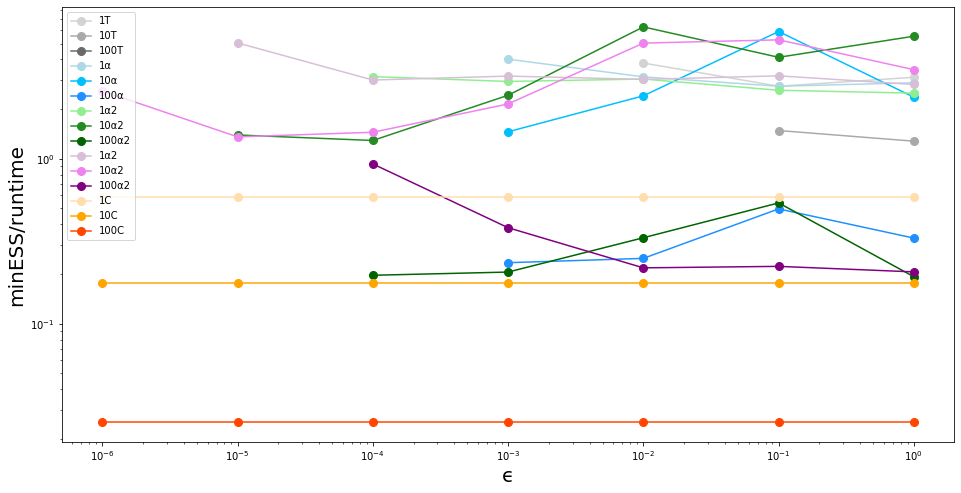

In [905]:
def show_only_positive_ap(cc, ap, ix):
    cc_copy = cc.copy()
    ap_copy = ap.copy()
    flag = ap_copy[:, ix] < 1e-8
    values = cc_copy[:, ix]
    values[flag] = np.nan
    return values

fig, ax = plt.subplots(figsize=(16, 8))
# α = 0.0
ax.plot(ϵs, show_only_positive_ap(OUT17, OUT18, 0), label='1T', marker='o', color='lightgray', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT17, OUT18, 1), label='10T', marker='o', color='darkgrey', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT17, OUT18, 2), label='100T', marker='o', color='dimgrey', markersize=8)
# α = 0.9
ax.plot(ϵs, show_only_positive_ap(OUT19, OUT20, 0), label='1α', marker='o', color='lightblue', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT19, OUT20, 1), label='10α', marker='o', color='deepskyblue', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT19, OUT20, 2), label='100α', marker='o', color='dodgerblue', markersize=8)
# α = 0.99
ax.plot(ϵs, show_only_positive_ap(OUT21, OUT22, 0), label='1α2', marker='o', color='lightgreen', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT21, OUT22, 1), label='10α2', marker='o', color='forestgreen', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT21, OUT22, 2), label='100α2', marker='o', color='darkgreen', markersize=8)
# α = 0.999
ax.plot(ϵs, show_only_positive_ap(OUT25, OUT26, 0), label='1α2', marker='o', color='thistle', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT25, OUT26, 1), label='10α2', marker='o', color='violet', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT25, OUT26, 2), label='100α2', marker='o', color='purple', markersize=8)
# α = 0.99
# ax.plot(ϵs, show_only_positive_ap(OUT3, OUT4, 0), label='1α', marker='o', color='lightblue', markersize=8)
# ax.plot(ϵs,  show_only_positive_ap(OUT3, OUT4, 1), label='10α', marker='o', color='deepskyblue', markersize=8)
# ax.plot(ϵs, show_only_positive_ap(OUT3, OUT4, 2), label='100α', marker='o', color='dodgerblue', markersize=8)
# C_RWM
# α = 0.995
# ax.plot(ϵs, OUT7[:, 0], label='1α2', marker='o', color='lightgreen', markersize=8)
# ax.plot(ϵs,  OUT7[:, 1], label='10α2', marker='o', color='forestgreen', markersize=8)
# ax.plot(ϵs, OUT7[:, 2], label='100α2', marker='o', color='darkgreen', markersize=8)
# Idk try averaged one
# ax.plot(ϵs, show_only_positive_ap(OUT9, OUT10, 0), label='1av', marker='o', color='thistle', markersize=8)
# ax.plot(ϵs,  show_only_positive_ap(OUT9, OUT10, 1), label='10av', marker='o', color='violet', markersize=8)
# ax.plot(ϵs, show_only_positive_ap(OUT9, OUT10, 2), label='100av', marker='o', color='purple', markersize=8)
# Idk try the one with tolerance=1e-16
ax.plot(ϵs, np.repeat(OUT23[0], len(ϵs)), label='1C', marker='o', color='navajowhite', markersize=8)
ax.plot(ϵs, np.repeat(OUT23[1], len(ϵs)), label='10C', marker='o', color='orange', markersize=8)
ax.plot(ϵs, np.repeat(OUT23[2], len(ϵs)), label='100C', marker='o', color='orangered', markersize=8)
# CRWM
# ax.plot(ϵs, np.repeat(OUT5[0], len(ϵs)), label='1C', marker='o', color='navajowhite', markersize=8)
# ax.plot(ϵs, np.repeat(OUT5[1], len(ϵs)), label='10C', marker='o', color='orange', markersize=8)
# ax.plot(ϵs, np.repeat(OUT5[2], len(ϵs)), label='100C', marker='o', color='orangered', markersize=8)
# ax.plot(ϵs, np.repeat(OUT11[0], len(ϵs)), label='1C', marker='o', color='navajowhite', markersize=8)
# ax.plot(ϵs, np.repeat(OUT11[1], len(ϵs)), label='10C', marker='o', color='orange', markersize=8)
# ax.plot(ϵs, np.repeat(OUT11[2], len(ϵs)), label='100C', marker='o', color='orangered', markersize=8)
# Set xticks
ax.set_xticks(ϵs)
# Set labels
ax.set_xlabel("ϵ", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
ax.legend()
plt.show()

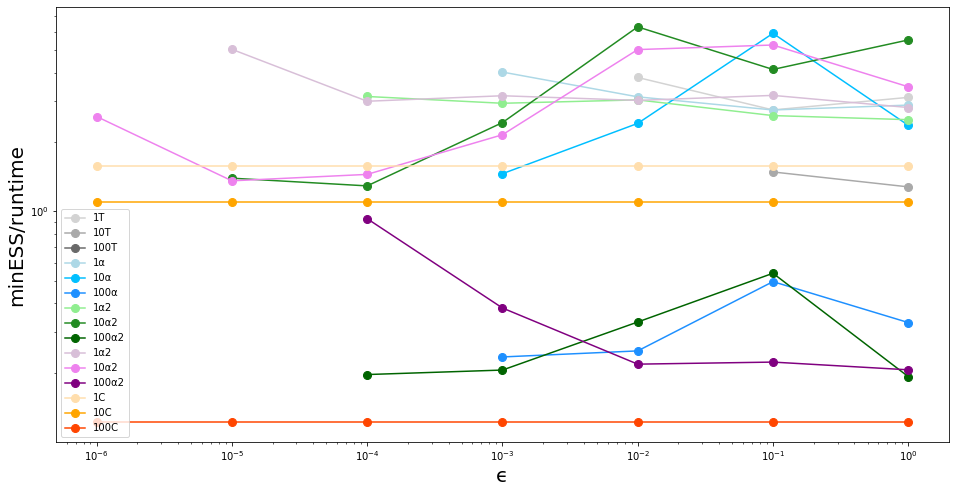

In [875]:
def show_only_positive_ap(cc, ap, ix):
    cc_copy = cc.copy()
    ap_copy = ap.copy()
    flag = ap_copy[:, ix] < 1e-8
    values = cc_copy[:, ix]
    values[flag] = np.nan
    return values

fig, ax = plt.subplots(figsize=(16, 8))
# α = 0.0
ax.plot(ϵs, show_only_positive_ap(OUT17, OUT18, 0), label='1T', marker='o', color='lightgray', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT17, OUT18, 1), label='10T', marker='o', color='darkgrey', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT17, OUT18, 2), label='100T', marker='o', color='dimgrey', markersize=8)
# α = 0.9
ax.plot(ϵs, show_only_positive_ap(OUT19, OUT20, 0), label='1α', marker='o', color='lightblue', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT19, OUT20, 1), label='10α', marker='o', color='deepskyblue', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT19, OUT20, 2), label='100α', marker='o', color='dodgerblue', markersize=8)
# α = 0.99
ax.plot(ϵs, show_only_positive_ap(OUT21, OUT22, 0), label='1α2', marker='o', color='lightgreen', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT21, OUT22, 1), label='10α2', marker='o', color='forestgreen', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT21, OUT22, 2), label='100α2', marker='o', color='darkgreen', markersize=8)
# α = 0.999
ax.plot(ϵs, show_only_positive_ap(OUT25, OUT26, 0), label='1α2', marker='o', color='thistle', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT25, OUT26, 1), label='10α2', marker='o', color='violet', markersize=8)
ax.plot(ϵs, show_only_positive_ap(OUT25, OUT26, 2), label='100α2', marker='o', color='purple', markersize=8)
# α = 0.99
# ax.plot(ϵs, show_only_positive_ap(OUT3, OUT4, 0), label='1α', marker='o', color='lightblue', markersize=8)
# ax.plot(ϵs,  show_only_positive_ap(OUT3, OUT4, 1), label='10α', marker='o', color='deepskyblue', markersize=8)
# ax.plot(ϵs, show_only_positive_ap(OUT3, OUT4, 2), label='100α', marker='o', color='dodgerblue', markersize=8)
# C_RWM
# α = 0.995
# ax.plot(ϵs, OUT7[:, 0], label='1α2', marker='o', color='lightgreen', markersize=8)
# ax.plot(ϵs,  OUT7[:, 1], label='10α2', marker='o', color='forestgreen', markersize=8)
# ax.plot(ϵs, OUT7[:, 2], label='100α2', marker='o', color='darkgreen', markersize=8)
# Idk try averaged one
# ax.plot(ϵs, show_only_positive_ap(OUT9, OUT10, 0), label='1av', marker='o', color='thistle', markersize=8)
# ax.plot(ϵs,  show_only_positive_ap(OUT9, OUT10, 1), label='10av', marker='o', color='violet', markersize=8)
# ax.plot(ϵs, show_only_positive_ap(OUT9, OUT10, 2), label='100av', marker='o', color='purple', markersize=8)
# Idk try the one with tolerance=1e-16
ax.plot(ϵs, np.repeat(OUT23[0], len(ϵs)), label='1C', marker='o', color='navajowhite', markersize=8)
ax.plot(ϵs, np.repeat(OUT23[1], len(ϵs)), label='10C', marker='o', color='orange', markersize=8)
ax.plot(ϵs, np.repeat(OUT23[2], len(ϵs)), label='100C', marker='o', color='orangered', markersize=8)
# CRWM
# ax.plot(ϵs, np.repeat(OUT5[0], len(ϵs)), label='1C', marker='o', color='navajowhite', markersize=8)
# ax.plot(ϵs, np.repeat(OUT5[1], len(ϵs)), label='10C', marker='o', color='orange', markersize=8)
# ax.plot(ϵs, np.repeat(OUT5[2], len(ϵs)), label='100C', marker='o', color='orangered', markersize=8)
# ax.plot(ϵs, np.repeat(OUT11[0], len(ϵs)), label='1C', marker='o', color='navajowhite', markersize=8)
# ax.plot(ϵs, np.repeat(OUT11[1], len(ϵs)), label='10C', marker='o', color='orange', markersize=8)
# ax.plot(ϵs, np.repeat(OUT11[2], len(ϵs)), label='100C', marker='o', color='orangered', markersize=8)
# Set xticks
ax.set_xticks(ϵs)
# Set labels
ax.set_xlabel("ϵ", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
ax.legend()
plt.show()

In [685]:
OUT24

array([0.722, 0.247, 0.   ])

In [870]:
NNN = 1000
BBB = 1
δδδ = 0.01
MAXITER = 50
__, _jacob_, __ap__ = check_n_jacobian_comp_per_newton_step(m=50, δ=δδδ, N_samples=NNN, B=BBB, tol=1e-14, rev_tol=1e-14, maxiter=MAXITER, norm_ord=np.inf)

Dimensionality:  50
Dim(ystar):  (50,)
Dim(ξ0):  (54,)
M dim and codim:  4 50


In [871]:
_jacob_

{'jacobian': 15738, 'density': 791}

In [872]:
__ap__.mean()*100

76.5

In [873]:
(((_jacob_['jacobian'] - 1) -2*BBB*NNN) / NNN) / 2

6.8685

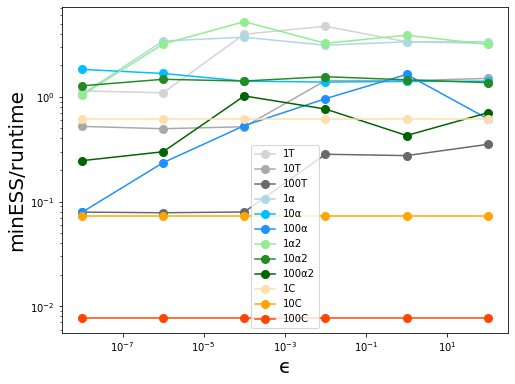

In [300]:
fig, ax = plt.subplots(figsize=(8, 6))
# α = 0.0
ax.plot(ϵs, OUT1[:, 0], label='1T', marker='o', color='lightgray', markersize=8)
ax.plot(ϵs, OUT1[:, 1], label='10T', marker='o', color='darkgrey', markersize=8)
ax.plot(ϵs, OUT1[:, 2], label='100T', marker='o', color='dimgrey', markersize=8)
# α = 0.99
ax.plot(ϵs, OUT3[:, 0], label='1α', marker='o', color='lightblue', markersize=8)
ax.plot(ϵs,  OUT3[:, 1], label='10α', marker='o', color='deepskyblue', markersize=8)
ax.plot(ϵs, OUT3[:, 2], label='100α', marker='o', color='dodgerblue', markersize=8)
# C_RWM
# α = 0.995
ax.plot(ϵs, OUT7[:, 0], label='1α2', marker='o', color='lightgreen', markersize=8)
ax.plot(ϵs,  OUT7[:, 1], label='10α2', marker='o', color='forestgreen', markersize=8)
ax.plot(ϵs, OUT7[:, 2], label='100α2', marker='o', color='darkgreen', markersize=8)
# CRWM
ax.plot(ϵs, np.repeat(OUT5[0], len(ϵs)), label='1C', marker='o', color='navajowhite', markersize=8)
ax.plot(ϵs, np.repeat(OUT5[1], len(ϵs)), label='10C', marker='o', color='orange', markersize=8)
ax.plot(ϵs, np.repeat(OUT5[2], len(ϵs)), label='100C', marker='o', color='orangered', markersize=8)
# Set xticks
ax.set_xticks(ϵs)
# Set labels
ax.set_xlabel("ϵ", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
ax.legend()
plt.show()

array([1., 1., 1.])

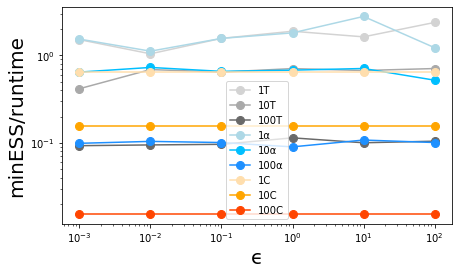

In [100]:
ϵs = generate_powers_of_ten(2, -3)
fig, ax = plt.subplots(figsize=(7, 4))
# \alpha = 0.0
ax.plot(ϵs, OUT1[:, 0], label='1T', marker='o', color='lightgray', markersize=8)
ax.plot(ϵs, OUT1[:, 1], label='10T', marker='o', color='darkgrey', markersize=8)
ax.plot(ϵs, OUT1[:, 2], label='100T', marker='o', color='dimgrey', markersize=8)
# \alpha = 0.99
ax.plot(ϵs, OUT3[:, 0], label='1α', marker='o', color='lightblue', markersize=8)
ax.plot(ϵs,  OUT3[:, 1], label='10α', marker='o', color='deepskyblue', markersize=8)
ax.plot(ϵs, OUT3[:, 2], label='100α', marker='o', color='dodgerblue', markersize=8)
# C_RWM
ax.plot(ϵs, np.repeat(OUT5[0], len(ϵs)), label='1C', marker='o', color='navajowhite', markersize=8)
ax.plot(ϵs, np.repeat(OUT5[1], len(ϵs)), label='10C', marker='o', color='orange', markersize=8)
ax.plot(ϵs, np.repeat(OUT5[2], len(ϵs)), label='100C', marker='o', color='orangered', markersize=8)
# Set xticks
ax.set_xticks(ϵs)
# Set labels
ax.set_xlabel("ϵ", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
ax.legend()
plt.show()

#### THUG $\alpha=0.0$

In [257]:
thug_cc = zeros((n_repeats, len(ϵs)))
thug_ap = zeros((n_repeats, len(ϵs)))
for (ix, ϵ), ystar, ξ0 in zip(enumerate(ϵs), ystars, ξ0s):
    for i in range(n_repeats):
        start_time = time.time()
        thug_samples, thug_acc = HugTangentialMultivariate(
            x0=ξ0,
            T=T,
            B=B,
            N=N_samples,
            α=0.0,
            q=q,
            logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵ),
            jac=Jf
        )
        runtimeTHUG = time.time() - start_time
        thug_cc[i, ix] = min(ESS_univariate(thug_samples)) / runtimeTHUG
        thug_ap[i, ix] = thug_acc.mean()

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [258]:
thug_ap

array([[0.099, 0.09 , 0.09 , 0.07 , 0.071, 0.003, 0.   , 0.   , 0.   ]])

In [259]:
thug_cc

array([[2.25062397, 2.23454935, 3.3465725 , 3.48601792, 2.41208196,
        2.2633078 , 0.73199789, 0.72906443, 0.75207981]])

In [246]:
thug_ap # B=5

array([[0.026, 0.026, 0.012, 0.02 , 0.02 , 0.   , 0.   , 0.   , 0.   ]])

In [247]:
thug_cc # B=5

array([[1.05537438, 0.99596645, 0.92910097, 0.9392884 , 1.1880153 ,
        0.33552317, 0.34298964, 0.34220148, 0.35596005]])

In [242]:
thug_ap # B=4

array([[0.061, 0.059, 0.069, 0.062, 0.042, 0.   , 0.   , 0.   , 0.   ]])

In [243]:
thug_cc # B=4

array([[1.24191826, 1.21655635, 1.09188854, 1.14036663, 2.1286346 ,
        0.28519889, 0.29809661, 0.32850118, 0.28386816]])

In [238]:
thug_ap # B=3

array([[0.143, 0.153, 0.162, 0.154, 0.143, 0.004, 0.   , 0.   , 0.   ]])

In [239]:
thug_cc # B=3

array([[1.66469694, 1.35755394, 2.5006561 , 1.51748013, 1.44082803,
        1.10348225, 0.41122055, 0.43176698, 0.42103632]])

In [234]:
thug_ap # B=2

array([[0.318, 0.34 , 0.337, 0.352, 0.361, 0.   , 0.   , 0.   , 0.   ]])

In [235]:
thug_cc

array([[2.15496453, 1.84860685, 1.54732782, 1.51066811, 1.94390491,
        0.47484866, 0.46572371, 0.46641199, 0.4737049 ]])

In [227]:
thug_ap # B=1

array([[0.649, 0.638, 0.63 , 0.615, 0.575, 0.022, 0.   , 0.   , 0.   ]])

In [228]:
thug_cc

array([[1.79728788, 1.52571648, 1.57215203, 1.80221206, 1.7765372 ,
        1.27643641, 0.52265855, 0.54514774, 0.48787008]])

#### THUG $\alpha=0.99$

In [248]:
thug99_cc = zeros((n_repeats, len(ϵs)))
thug99_ap = zeros((n_repeats, len(ϵs)))
for (ix, ϵ), ystar, ξ0 in zip(enumerate(ϵs), ystars, ξ0s):
    for i in range(n_repeats):
        start_time = time.time()
        thug_samples99, thug_acc99 = HugTangentialMultivariate(
            x0=ξ0,
            T=T,
            B=B,
            N=N_samples,
            α=0.99,
            q=q,
            logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵ),
            jac=Jf
        )
        runtimeTHUG99 = time.time() - start_time
        thug99_cc[i, ix] = min(ESS_univariate(thug_samples99)) / runtimeTHUG99
        thug99_ap[i, ix] = thug_acc99.mean()

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [249]:
thug99_ap # B=5

array([[0.27 , 0.249, 0.252, 0.246, 0.272, 0.274, 0.218, 0.029, 0.   ]])

In [250]:
thug99_cc #B=5

array([[2.96730067, 1.774103  , 2.83080326, 6.43092352, 8.97395294,
        2.66354743, 2.15956214, 1.03148518, 0.33428125]])

# RWM with $s=T$

In [67]:
rwm_cc = zeros((n_repeats, len(ϵs)))
rwm_ap = zeros((n_repeats, len(ϵs)))
for (ix, ϵ), ystar, ξ0 in zip(enumerate(ϵs), ystars, ξ0s):
    for i in range(n_repeats):
        start_time = time.time()
        rwm_samples, rwm_acc = RWM(x0=ξ0, s=T, N=N_samples, logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ))
        runtimeRWM = time.time() - start_time
        rwm_cc[i, ix] = min(ESS_univariate(rwm_samples)) / runtimeRWM
        rwm_ap[i, ix] = rwm_acc.mean()

# C-RWM

In [912]:
class GKManifold(Manifold):
    def __init__(self, ystar):
        self.m = len(ystar)            # Number constraints = dimensionality of the data
        self.d = 4                     # Manifold has dimension 4 (like the parameter θ)
        self.n = self.d + self.m       # Dimension of ambient space is m + 4
        self.ystar = ystar

    def q(self, ξ):
        """Constraint for toy BIP."""
        with catch_warnings():
            filterwarnings('error')
            try:
                return (ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]) - self.ystar
            except RuntimeWarning:
                raise ValueError("Constraint found Overflow warning.")

    def Q(self, ξ):
        """Transpose of Jacobian for toy BIP. """
        return Jf_transpose(ξ)
    
    def compute_J(self, ξ):
        """Safely computes Jacobian."""
        with catch_warnings():
            filterwarnings('error')
            try:
                return Jf(ξ)
            except RuntimeWarning:
                raise ValueError("J computation found Runtime warning.")
                
    def logprior(self, ξ):
        """Log prior distribution."""
        θ, z = ξ[:4], ξ[4:]
        with catch_warnings():
            filterwarnings('error')
            try:
                theta_prior_term = (np.log(θ/10) + np.log(1-θ/10)).sum()
                z_prior_term = -z@z/2
                return theta_prior_term + z_prior_term
            except RuntimeWarning:
                return -np.inf

    def logpost(self, ξ):
        """log posterior for c-rwm"""
        θ, z = ξ[:4], ξ[4:]
        try:
            J = self.compute_J(ξ)
            logprior = self.logprior(ξ)
            correction_term  = - math.prod(np.linalg.slogdet(J@J.T))/2 
            return  logprior + correction_term
        except ValueError as e:
            return -np.inf
            
#         if Jsuccessful:
#             theta_prior_term = (np.log(θ/10) + np.log(1-θ/10)).sum()
#             z_prior_term     = - z@z/2
#             correction_term  = - math.prod(np.linalg.slogdet(J@J.T))/2 
#             return  theta_prior_term + z_prior_term + correction_term
#         else:
#             return -np.inf
        #return (np.log(θ/10) + np.log(1-θ/10)).sum() - np.log(det(J@J.T))/2 -z@z/2
    
    def logp(self, v):
        """Log density for normal on the tangent space."""
        return MVN(mean=zeros(self.d), cov=eye(self.d)).logpdf(v)

In [901]:
def zappa_sampling_storecomps_rattle(x0, manifold, n, T, B, tol, rev_tol, maxiter=50, norm_ord=2):
    """
    Same as `zappa_sampling_storecomps` except here we don't just do a single step with step size \sigma. 
    Instead, here we basically use RATTLE but with V(x) = constant, so that all the unconstrained momentum
    updates using \nabla V will not be performed. 
    This version of the algorithm allows us to compare it against THUG. Indeed suppose THUG is run with parameters
    T and B (integration time and number of bounces). Then how do you run Zappa? With sigma=T? With sigma=T/B? 
    Using this function, one can run zappa with T and B, hence leading to a fairer comparison. 
    
    TOL:      tolerance for non-linear projection (Newton's algorithm)
    REV_TOL:  tolerance for checking reversibility.

    x0 : Numpy Array 
         Initial point on the manifold. Has dimension (d,) where d is the manifold dimension.

    manifold : Manifold
               Object of Manifold class.

    logf : callable
           Function computing log-target density constrained on the manifold. In most cases, this 
           is uniform and the function should output log(1) = 0. Takes as input a vector of 
           dimension (d + m, )

    n : Int
        Number of samples

    T : Float
        Integration time

    B : Int
        Number of RATTLE steps

    tol : Float
          Tolerance for root-finding algorithm used to find a.

    Returns the samples as an array of dimensions (n, d + m)
    """
    assert type(B) == int
    assert norm_ord in [2, np.inf]
    # Check arguments
    n = int(n)
    B = int(B)
    δ = T / B
    d, m = manifold.get_dimension(), manifold.get_codimension()

    # Choose how to compute Qx @ a based on the dimensionality
#     if m == 1:
#         compute_Qxa = lambda Qx, a: a*Qx.flatten()
#     else:
#         compute_Qxa = lambda Qx, a: Qx @ a

    # Initial point on the manifold
    x = x0

    # House-keeping
    samples = zeros((n, d + m))    # Store n samples on the manifold
    samples[0, :] = x
    i = 1
    N_EVALS = {'jacobian': 0, 'density': 0}
    ACCEPTED = zeros(n)
    
    # Define function to compute Jacobian. 
#     def compute_J(x):
#         """Computes jacobian but also returns a flag as to whether the computation worked or not."""
#         successful = True
#         try:
#             J = manifold.Q(x).T
#             return J, successful
#         except ValueError as e:
#             print("Jacobian computation failed with error: ", e)
#             successful = False
#             return zeros_like(J), successful
    compute_J = manifold.compute_J
    # Define function to compute density
    def logη(x):
        """Computes log density on Manifold but makes sure everything is behaving nicely."""
        return manifold.logpost(x)

    # Log-uniforms for MH accept-reject step
    logu = log(rand(n))

    # Compute jacobian & density value
    Jx    = compute_J(x) #manifold.Q(x).T
    logηx = logη(x)
    N_EVALS['jacobian'] += 1
    N_EVALS['density'] += 1

    # Function to project onto tangent space
    def qr_project(v, J):
        """Projects using QR decomposition."""
        Q, _ = qr(J.T, mode='economic')
        return Q @ (Q.T @ v)
    
    def linear_project(v, J):
        """Projects by solving linear system."""
        return J.T @ solve(J@J.T, J@v)
        #return J.T.dot(solve(J.dot(J.T), J.dot(v)))

    # Constrained Step Function
    def constrained_rwm_step(x, v, tol, maxiter, Jx, norm_ord=norm_ord):
        """Used for both forward and backward. See Manifold-Lifting paper."""
        # Project momentum
        v_projected = v - linear_project(v, Jx) #qr_project(v, Jx)
        # Unconstrained position step
        x_unconstr = x + v_projected
        # Position Projection
        a, flag, n_grad = project_zappa(manifold, x_unconstr, Jx.T, tol, maxiter, norm_ord=norm_ord)
        y = x_unconstr - Jx.T @ a #x_unconstr + Jx.T @ a #compute_Qxa(Jx.T, a)
#         print("y found on M? ", is_on_manifold(y, ystar))
        try:
            Jy = compute_J(y) #manifold.Q(y).T
        except ValueError as e:
            print("Jacobian computation at projected point failed. ", e)
            return x, v, Jx, 0, n_grad + 1
        # backward velocity
        v_would_have = y - x
        # Find backward momentum & project it to tangent space at new position
        v_projected_endposition = v_would_have - linear_project(v_would_have, Jy) #qr_project(v_would_have, Jy) #qr_project((y - x) / δ, Jy)
        # Return projected position, projected momentum and flag
#         print("CRWMStep. ||Proj v - v||=", np.linalg.norm(v_projected - v), " ||v||=", np.linalg.norm(v), " ||v_projected||=", np.linalg.norm(v_projected), " ||y-x||=", np.linalg.norm(y-x), "flag=", flag, " ||a||=", np.linalg.norm(a), "is x_unconstr on Manifold? ", is_on_manifold(x_unconstr, ystar), " ||v_projected_endposition||=", np.linalg.norm(v_projected_endposition), " ||x_unconstr-x||=", np.linalg.norm(x_unconstr-x), " ||Qxa||=", np.linalg.norm(Jx.T @ a), "norm()=", "norm()=", la.norm(manifold.q(x_unconstr- Jx.T@a)))
        return y, v_projected_endposition, Jy, flag, n_grad + 1
    
    def constrained_leapfrog(x0, v0, J0, B, tol, rev_tol, maxiter, norm_ord=norm_ord):
        """Constrained Leapfrog/RATTLE."""
        successful = True
        n_jacobian_evaluations = 0
        x, v, J = x0, v0, J0
        for _ in range(B):
#             print("Leapfrog Step: ", _)
#             print("\tStarting step ", _, " from ||x||=", np.linalg.norm(x))
            xf, vf, Jf, converged_fw, n_fw = constrained_rwm_step(x, v, tol, maxiter, J, norm_ord=norm_ord)
#             print("\tConstrained Step FW: ", n_fw)
#             print("After FW Constrained Step. ||xf-x||=", np.linalg.norm(xf-x), "converged_fw=", converged_fw, " ||vf||=", np.linalg.norm(vf), "xf on M=", is_on_manifold(xf, ystar))
            xr, vr , Jr, converged_bw, n_bw = constrained_rwm_step(xf, -vf, tol, maxiter, Jf, norm_ord=norm_ord)
#             print("\tConstrained Step BW: ", n_bw)
#             print("After BW Constrained Step. ||xr-x||=", np.linalg.norm(xr-x), "converged_bw=", converged_bw, " ||vr||=", np.linalg.norm(vr), "xr on M=", is_on_manifold(xr, ystar))
            n_jacobian_evaluations += (n_fw + n_bw)  # +2 due to the line Jy = manifold.Q(y).T
            if (not converged_fw) or (not converged_bw) or (np.linalg.norm(xr - x, ord=norm_ord) >= rev_tol):
#                 print("Failed")
                successful = False
                return x0, v0, J0, successful, n_jacobian_evaluations
            else:
#                 print("\tStep ", _, " successful. ||x||=", np.linalg.norm(x), "||xf-x||=", np.linalg.norm(xf-x))
                x = xf
                v = vf
                J = Jf
        return x, v, J, successful, n_jacobian_evaluations

    for i in range(n):
#         print("Iteration: ", i)
        v = δ*randn(m + d) # Sample in the ambient space.
        xp, vp, Jp, LEAPFROG_SUCCESSFUL, n_jac_evals = constrained_leapfrog(x, v, Jx, B, tol=tol, rev_tol=rev_tol, maxiter=maxiter)
        N_EVALS['jacobian'] += n_jac_evals
        if LEAPFROG_SUCCESSFUL:
            logηp = logη(xp)
            N_EVALS['density'] += 1
#             print(np.linalg.norm(xp - x), logfp, logfx, logfp-logfx)
            if logu[i] <= logηp - logηx - (vp@vp)/2 + (v@v)/2: 
                # Accept
                ACCEPTED[i - 1] = 1
                x, logηx, Jx = xp, logηp, Jp
                samples[i, :] = xp
            else:
                # Reject
                samples[i, :] = x
                ACCEPTED[i - 1] = 0
        else:
            # Reject
            samples[i, :] = x
            ACCEPTED[i - 1] = 0
    return samples, N_EVALS, ACCEPTED

In [902]:
def project_zappa(manifold, z, Q, tol = 1.48e-08 , maxiter = 50, atol=1e-8, norm_ord=2):
    '''
    This version is the version of Miranda & Zappa. It retuns i, the number of iterations
    i.e. the number of gradient evaluations used.
    '''
    a, flag, i = np.zeros(Q.shape[1]), 1, 0

    # Compute the constrained at z - Q@a. If it fails due to overflow error, return a rejection altogether.
    try:
        projected_value = manifold.q(z - Q@a)
    except ValueError as e:
        return a, 0, i
    # While loop
    while la.norm(projected_value, ord=norm_ord) >= tol:
        try:
            Jproj = manifold.compute_J(z - Q@a)
        except ValueError as e:
            print("Jproj failed. ", e)
            return zeros(Q.shape[1]), 0, i
        # Check that Jproj@Q is invertible. Do this by checking condition number 
        # see https://stackoverflow.com/questions/13249108/efficient-pythonic-check-for-singular-matrix
        GramMatrix = Jproj@Q
        if np.linalg.cond(GramMatrix) < 1/np.finfo(z.dtype).eps:
            Δa = la.solve(GramMatrix, projected_value)
            a += Δa
            i += 1
            if i > maxiter:
                return zeros(Q.shape[1]), 0, i
            # If we are not at maxiter iteration, compute new projected value
            try:
                projected_value = manifold.q(z - Q@a)
            except ValueError as e:
                return zeros(Q.shape[1]), 0, i
        else:
            # Fail
            return zeros(Q.shape[1]), 0, i
    # At the end, check that the found a is not too small.
    if la.norm(a, ord=norm_ord) <= atol:
        return zeros(Q.shape[1]), 0, i
    else:
        return a, 1, i
    
    
    
#     try:
#         while la.norm(q(z - Q@a), ord=norm_ord) >= tol:
#             delta_a = la.solve(grad_q(z - Q@a).transpose()@Q, q(z - Q@a))
#             a += delta_a
#             i += 1
#             if i > maxiter:
#                 flag = 0
#                 return a, flag, i
#     except ValueError as e:
#         flag = 0
#         return a, flag, i
#     except ValueError as e:
#         # print("z: ", z@z)
#         # print("Q: ", Q)
#         # print("a: ", a, a@a)
#         # print("FAILED")
#         flag = 0
#         return a, flag, i
    # If a is basically zero, then we have actually failed.
#     if la.norm(a, ord=norm_ord) <= atol:
#         flag = 0
#         return a, flag, i
#     else:
#         return a, flag, i

In [213]:
n_repeats_crwm = 1
crwm_cc = zeros(n_repeats_crwm)
crwm_ap = zeros(n_repeats_crwm)
for i in range(n_repeats_crwm):
    # Prep manifold
    manifold = GKManifold(ystar=ystar)
    # Run
    start_time = time.time()
    crwm_samples, crwm_evals, crwm_acc  = zappa_sampling_storecomps_rattle(ξ0_found, manifold, manifold.logpost, 10, T, B, tol=1e-10, rev_tol=1e-8)
    runtimeCRWM = time.time() - start_time
    crwm_cc[i] = min(ESS_univariate(crwm_samples)) / runtimeCRWM
    crwm_ap[i] = crwm_acc.mean()

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_35226/712030013.py:10: RuntimeWarning: overflow encountered in exp
  return ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:] - self.ystar
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_35226/712030013.py:10: RuntimeWarning: invalid value encountered in true_divide
  return ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:] - self.ystar
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_35226/712030013.py:10: RuntimeWarning: overflow encountered in power
  return ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:] - self.ystar


In [229]:
n_repeats_crwm = 1
crwm_cc = zeros(n_repeats_crwm)
crwm_ap = zeros(n_repeats_crwm)
for i in range(n_repeats_crwm):
    # Prep manifold
    manifold = GKManifold(ystar=ystar)
    # Run
    start_time = time.time()
    crwm_samples, crwm_evals, crwm_acc  = zappa_sampling_storecomps(ξ0_found, manifold, manifold.logpost, manifold.logp, N_samples, δ, tol=1e-10)
    runtimeCRWM = time.time() - start_time
    crwm_cc[i] = min(ESS_univariate(crwm_samples)) / runtimeCRWM
    crwm_ap[i] = crwm_acc.mean()

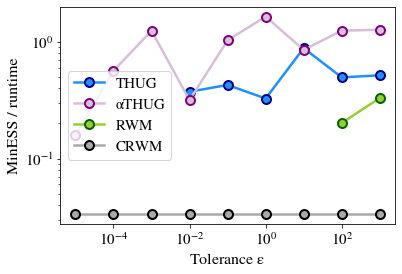

In [143]:
# process data so that when there is a zero acceptance probability, we put NaN
def process(cc, ap):
    cc_mean = nanmean(cc, axis=0)
    cc_mean[ap.mean(axis=0) <= 1e-16] = np.nan
    return cc_mean


    

# Plot minESS/time as \sigma varies, in log-log scale
max_index = len(ϵs)
rc('font',**{'family':'STIXGeneral'})
fig, ax = plt.subplots()
ax.plot(ϵs[:max_index], process(thug_cc, thug_ap)[:max_index], label='THUG', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='navy', color='dodgerblue', markeredgewidth=2.0)
ax.plot(ϵs[:max_index], process(thug99_cc, thug99_ap)[:max_index], label='αTHUG', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='purple', color='thistle', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], process(hmc_cc, hmc_ap)[:max_index], label='HMC', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='brown', color='lightcoral', markeredgewidth=2.0)
ax.plot(ϵs[:max_index], process(rwm_cc, rwm_ap)[:max_index], label='RWM', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='darkgreen', color='yellowgreen', markeredgewidth=2.0)
ax.plot(ϵs[:max_index], np.repeat(crwm_cc.mean(), max_index), label='CRWM', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='black', color='darkgrey', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], nanmean(chmc_cc, axis=0)[:max_index], label='CHMC', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='black', color='darkgrey', markeredgewidth=2.0)
# ax.plot(σlist, nanmean(THUG_CC99, axis=1), label='THUG99', marker='o')
# ax.plot(σlist, nanmean(THUG_CC90, axis=1), label='THUG90', marker='o')
# ax.plot(σlist, nanmean(THUG_CC95, axis=1), label='THUG95', marker='o')
# ax.plot(σlist, nanmean(THUG_CC995, axis=1), label='THUG995', marker='o')
# ax.plot(σlist, nanmean(THUG_CC80, axis=1), label='THUG80', marker='o')
# ax.plot(σlist, nanmean(THUG_CC50, axis=1), label='THUG50', marker='o')
ax.set_xlabel(r'Tolerance ' + r'$\mathregular{\epsilon}$', fontsize=16)
ax.set_ylabel(r'MinESS / runtime', fontsize=16)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
ax.loglog()
# ax.set_xticks(ticks=ϵs[:max_index], labels=['$\mathregular{{10^{{}}}}$'.format(-i) for i in range(len(ϵs))])
# ax.set_ylim([-1, 5])
# ax.set_xscale('log')
#plt.savefig('figures/computational_cost_gk_as_sigma_decreases.png', dpi=300)
plt.show()